In [1]:
import sim
import numpy as np
import sympy as sp

def connect(port):
# Establece la conexión a CoppeliaSim
# port debe coincidir con el puerto de conexión en VREP
# retorna el número de cliente o -1 si no puede establecer conexión
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

# Conectarse al servidor de VREP
# *** ejecutar cada vez que se reinicia la simulación ***
clientID = connect(19999)

retCode,Dummy=sim.simxGetObjectHandle(clientID,'Dummy',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'joint2',sim.simx_opmode_blocking)
print(Dummy, joint1, joint2)

conectado a 19999
21 17 19


In [30]:
# Comenzamos desde la descripción de Denavit-Hartenberg
#      theta     |      d      |      a      |    alpha
# ----------------------------------------------------------
#       q1             0             0.2            0
#       q2             0             0.2            0

In [2]:
# Definimos una función para construir las matrices de transformación
# en forma simbóĺica a partir de los parámetros D-H

def symTfromDH(theta, d, a, alpha):
    # theta y alpha en radianes
    # d y a en metros
    Rz = sp.Matrix([[sp.cos(theta), -sp.sin(theta), 0, 0],
                   [sp.sin(theta), sp.cos(theta), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    tz = sp.Matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, d],
                   [0, 0, 0, 1]])
    ta = sp.Matrix([[1, 0, 0, a],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    Rx = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    T = Rz*tz*ta*Rx
    return T

In [3]:
# La matriz de transformación desde la base al dummy es
q1 = sp.symbols('q1')
q2 = sp.symbols('q2')

T = sp.simplify(symTfromDH(q1, 0, 0.2, 0)* symTfromDH(q2, 0, 0.2, 0))
T

Matrix([
[cos(q1 + q2), -sin(q1 + q2), 0, 0.2*cos(q1) + 0.2*cos(q1 + q2)],
[sin(q1 + q2),  cos(q1 + q2), 0, 0.2*sin(q1) + 0.2*sin(q1 + q2)],
[           0,             0, 1,                              0],
[           0,             0, 0,                              1]])

In [48]:
# Para ver que tan alto está posicionado el robot
returnCode,altura=sim.simxGetObjectPosition(clientID, dummy, -1, sim.simx_opmode_blocking)
print(round(altura[0],3))

# Ubicar el piso a una distancia
altura = 0.3
limite = 2 * np.pi

0.4


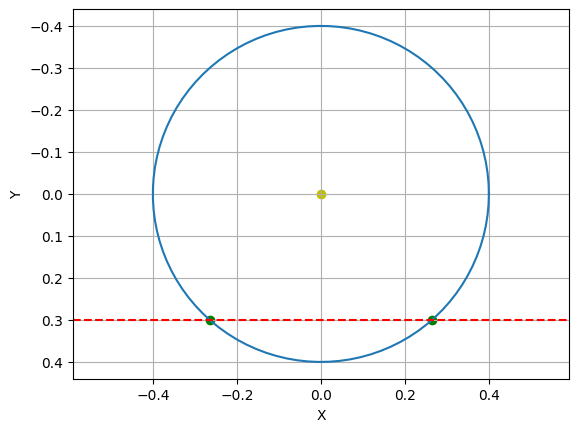

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def find_intersection_points(center, radius, line_slope, line_intercept):
    a = 1 + line_slope**2
    b = -2 * center[0] + 2 * line_slope * (line_intercept - center[1])
    c = center[0]**2 + (line_intercept - center[1])**2 - radius**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return []  # No intersection points

    x1 = (-b + np.sqrt(discriminant)) / (2*a)
    x2 = (-b - np.sqrt(discriminant)) / (2*a)
    y1 = line_slope * x1 + line_intercept
    y2 = line_slope * x2 + line_intercept

    return [(x1, y1), (x2, y2)]

# Parámetros de la circunferencia y la recta
center = (0, 0)
radius = 0.4
line_slope = 0
line_intercept = 0.3

# Encontrar puntos de intersección
intersection_points = find_intersection_points(center, radius, line_slope, line_intercept)

# Plot de la circunferencia y la recta
theta = np.linspace(0, 2*np.pi, 100)
x_circle = center[0] + radius * np.cos(theta)
y_circle = center[1] + radius * np.sin(theta)

plt.plot(x_circle, y_circle, label='Circunferencia')
plt.axhline(y=line_intercept, color='r', linestyle='--', label='Recta')
plt.scatter([point[0] for point in intersection_points], [point[1] for point in intersection_points], color='g', label='Puntos de intersección')
plt.scatter(0, 0, color='y', label='Muslo')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis()  
plt.axis('equal')
#plt.legend()
plt.grid(True)
plt.show()

In [5]:
import numpy as np

def find_intersection_points(center, radius, line_slope, line_intercept):
    a = 1 + line_slope**2
    b = -2 * center[0] + 2 * line_slope * (line_intercept - center[1])
    c = center[0]**2 + (line_intercept - center[1])**2 - radius**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return []  # No intersection points

    x1 = (-b + np.sqrt(discriminant)) / (2*a)
    x2 = (-b - np.sqrt(discriminant)) / (2*a)
    y1 = line_slope * x1 + line_intercept
    y2 = line_slope * x2 + line_intercept

    return [(x1, y1), (x2, y2)]

# Parámetros de la circunferencia y la recta
center = (0, 0) # Posicion motor muslo
radius = 0.4 # Largo de la pierna
line_slope = 0
line_intercept = 0.3

# Encontrar puntos de intersección
intersection_points = find_intersection_points(center, radius, line_slope, line_intercept)
print(intersection_points)

[(0.26457513110645914, 0.3), (-0.26457513110645914, 0.3)]


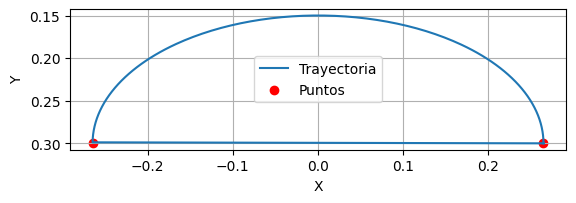

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def create_oval_through_points(point1, point2, altura,cantidad_puntos):
    x1, y1 = point1
    x2, y2 = point2
    
    # Calcular el ancho y la altura utilizando los puntos dados
    if x1 > x2:
        width = x1*2
    elif x1 < x2:
        width = x2*2
    height = altura
    
    # Calcular el centro del óvalo
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    # Generar el óvalo utilizando las dimensiones calculadas
    theta = np.linspace(0, 2 * np.pi, cantidad_puntos*2)
    x = center_x + width/2 * np.cos(theta)
    y = center_y + height/2 * np.sin(theta)
    
    return x, y

# Puntos que definen el óvalo
point1 = intersection_points[0]
point2 = intersection_points[1]

# Crear el óvalo que pasa por los puntos dados
x, y = create_oval_through_points(point1, point2, 0.3,200)

mov_x = []
mov_y = []
for i in range(len(y)):
    if y[i] <= 0.3: # Si es menor que la distancia del robot al piso se puede elevar la pata
        mov_x.append(x[i])
        mov_y.append(y[i])

# Plot del óvalo
plt.plot(mov_x, mov_y, label='Trayectoria')
plt.scatter([point1[0], point2[0]], [point1[1], point2[1]], color='r', label='Puntos')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()

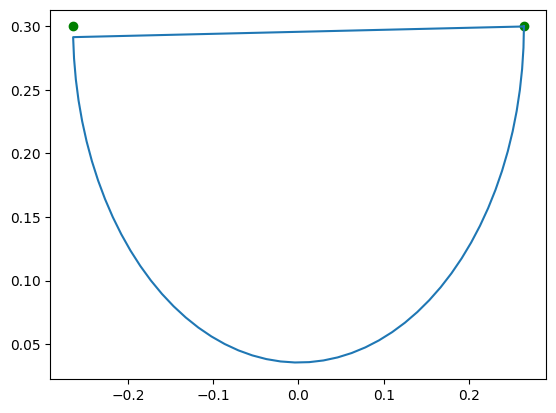

In [7]:
# Semi Circulo
def create_circle(point1, point2):
    center = ((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2)
    radius = np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) / 2
    theta = np.linspace(0, 2*np.pi, 100)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    return x, y

# Puntos que definen el diámetro
point1 = intersection_points[0]
point2 = intersection_points[1]

mov_x = []
mov_y = []

# Crear el círculo
x, y = create_circle(point1, point2)
for i in range(len(y)):
    if y[i] <= 0.3: # Si es menor que la distancia del robot al piso se puede elevar la pata
        mov_x.append(x[i])
        mov_y.append(y[i])
        
         

# Plot del círculo
plt.scatter([point1[0], point2[0]], [point1[1], point2[1]], color='g', label='Puntos del Diámetro')
plt.plot(mov_x, mov_y, label='Circunferencia')

In [8]:

aux1 = [0.3 for i in range(50)]
mov_y = mov_y + aux1
aux1 = np.linspace(mov_x[len(mov_x)-1], mov_x[1], 50)
mov_x = np.concatenate((mov_x,aux1))


In [9]:
import numpy as np
import matplotlib.pyplot as plt


#-------------------------------------------------------------------------
#
#                       Funciones de la trayectoria
#
#-------------------------------------------------------------------------
def find_intersection_points(center, radius, line_slope, line_intercept):
    a = 1 + line_slope**2
    b = -2 * center[0] + 2 * line_slope * (line_intercept - center[1])
    c = center[0]**2 + (line_intercept - center[1])**2 - radius**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return []  # No intersection points

    x1 = (-b + np.sqrt(discriminant)) / (2*a)
    x2 = (-b - np.sqrt(discriminant)) / (2*a)
    y1 = line_slope * x1 + line_intercept
    y2 = line_slope * x2 + line_intercept

    return [(x1, y1), (x2, y2)]

def create_oval_through_points(point1, point2, altura, cantidad_puntos):
    x1, y1 = point1
    x2, y2 = point2
    
    # Calcular el ancho y la altura utilizando los puntos dados
    if x1 > x2:
        width = x1*2
    elif x1 < x2:
        width = x2*2
    height = altura
    
    # Calcular el centro del óvalo
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    # Generar el óvalo utilizando las dimensiones calculadas
    theta = np.linspace(0, 2 * np.pi, cantidad_puntos*2)
    x = center_x + width/2 * np.cos(theta)
    y = center_y + height/2 * np.sin(theta)
    
    return x, y


#-------------------------------------------------------------------------
#
#                       Parametrización
#
#------------------------------------------------------------------------

# Parámetros de la circunferencia y la recta
center = (0, 0)
radius = 0.4
line_slope = 0
line_intercept = 0.3

# Encontrar puntos de intersección
intersection_points = find_intersection_points(center, radius, line_slope, line_intercept)

# Puntos que definen el óvalo
point1 = intersection_points[0]
point2 = intersection_points[1]

# Crear el óvalo que pasa por los puntos dados
#                                               , altura)
x, y = create_oval_through_points(point1, point2, 0.3, 200)

mov_x = []
mov_y = []
for i in range(len(y)):
    if y[i] <= 0.3: # Si es menor que la distancia del robot al piso se puede elevar la pata
        mov_x.append(x[i])
        mov_y.append(y[i])

#--------------------------------------------------------
#
#       aGREGAR EL ARRASTE, LA LINEA RECTA
#
#--------------------------------------------------------

aux1 = [0.3 for i in range(len(mov_y))]
mov_y = mov_y + aux1
aux1 = np.linspace(mov_x[len(mov_x)-1], mov_x[1], len(mov_x))
mov_x = np.concatenate((mov_x,aux1))

In [10]:
inv_mov_y1 = mov_y[::-1]
inv_mov_x1 = mov_x[::-1]
for i in range(len(inv_mov_y1)):
    # Ejemplo de nuevas coordenadas
    #a=mov_y[i]
    #b=mov_x[i]
    a=inv_mov_y1[i]
    b=inv_mov_x1[i]
    # definimos las ecuaciones a resolver
    ec1, ec2 = T[3]-a, T[7]-b
    (ec1, ec2)
    # ahora resolvemos la ecuación utilizando nsolve()
    try:
        q = sp.nsolve((ec1, ec2),(q1,q2),(1,-1), prec=6)
    except:
        print(a,b)
        print("no se pudo calcular")
        q = [0, 0, 0]
    
    # enviamos los ángulos al robot
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)

0.3 -0.24604695789252318
no se pudo calcular
0.1617022271107769 -0.10245016587409396
no se pudo calcular
0.1626340010017414 -0.10627861964242429
no se pudo calcular
0.17129329683033825 -0.13587918148835362
no se pudo calcular
0.17378295434993815 -0.14296044785043244
no se pudo calcular


In [12]:
import pandas as pd

df = pd.DataFrame(columns=['Muslo', 'Rodilla'])

inv_mov_y1 = mov_y[::-1]
inv_mov_x1 = mov_x[::-1]
for i in range(len(inv_mov_y1)):
    # Ejemplo de nuevas coordenadas
    #a=mov_y[i]
    #b=mov_x[i]
    a=inv_mov_y1[i]
    b=inv_mov_x1[i]
    # definimos las ecuaciones a resolver
    ec1, ec2 = T[3]-a, T[7]-b
    (ec1, ec2)
    # ahora resolvemos la ecuación utilizando nsolve()
    try:
        q = sp.nsolve((ec1, ec2),(q1,q2),(1,-1), prec=6)
        df.loc[len(df)] = {'Muslo': q[0], 'Rodilla': q[1]}
    except:
        print(a,b)
        print("no se pudo calcular")
        q = [0, 0, 0]
        
        
#retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
#retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)

0.3 -0.24604695789252318
no se pudo calcular
0.1617022271107769 -0.10245016587409396
no se pudo calcular
0.1626340010017414 -0.10627861964242429
no se pudo calcular
0.17129329683033825 -0.13587918148835362
no se pudo calcular
0.17378295434993815 -0.14296044785043244
no se pudo calcular


<function matplotlib.pyplot.show(close=None, block=None)>

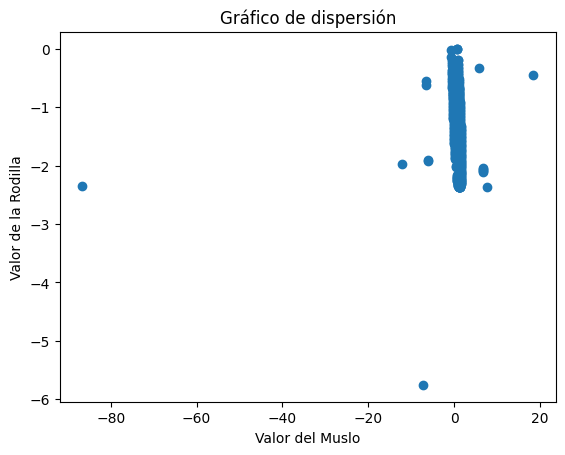

In [14]:
plt.scatter(x=df['Muslo'], y=df['Rodilla'])
plt.xlabel('Valor del Muslo')
plt.ylabel('Valor de la Rodilla')
plt.title('Gráfico de dispersión')
plt.show

In [37]:
df = pd.DataFrame(columns=['Muslo', 'Rodilla'])

for i in range(len(mov_y)):
    a=mov_y[i]
    b=mov_x[i]
    # definimos las ecuaciones a resolver
    ec1, ec2 = T[3]-a, T[7]-b
    (ec1, ec2)
    # ahora resolvemos la ecuación utilizando nsolve()
    try:
        q = sp.nsolve((ec1, ec2),(q1,q2),(1,-1), prec=6)
        df.loc[len(df)] = {'Muslo': q[0], 'Rodilla': q[1]}
    except:
        print(a,b)
        print("no se pudo calcular")
        q = [0, 0, 0]

filtro_1 = df['Muslo'] <= -3.5 # Borrar
filtro_2 = df['Muslo'] >= 3.5 # Borrar

df2 = df.drop(df[filtro_1].index)
df2 = df2.drop(df[filtro_2].index)



df2 = df2.drop([0, len(df2)-1])

0.17378295434993815 -0.14296044785043244
no se pudo calcular
0.17129329683033825 -0.13587918148835362
no se pudo calcular
0.1626340010017414 -0.10627861964242429
no se pudo calcular
0.1617022271107769 -0.10245016587409396
no se pudo calcular
0.3 -0.24604695789252318
no se pudo calcular


<function matplotlib.pyplot.show(close=None, block=None)>

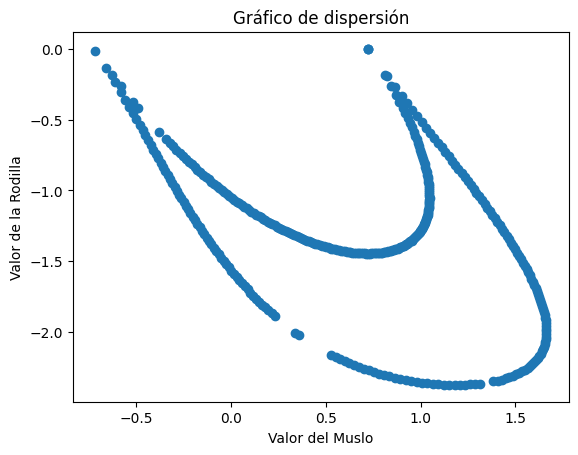

In [16]:
filtro_1 = df['Muslo'] <= -3.5 # Borrar
filtro_2 = df['Muslo'] >= 3.5 # Borrar

df2 = df.drop(df[filtro_1].index)
df2 = df2.drop(df[filtro_2].index)


plt.scatter(x=df2['Muslo'], y=df2['Rodilla'])
plt.xlabel('Valor del Muslo')
plt.ylabel('Valor de la Rodilla')
plt.title('Gráfico de dispersión')
plt.show

In [41]:
import time
for index, row in df2.iterrows():
    retCode = sim.simxSetJointTargetPosition(clientID, muslo3, row['Muslo'], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, rodilla3, row['Rodilla'], sim.simx_opmode_oneshot)
    time.sleep(0.001) #delay entre cada movimiento

KeyboardInterrupt: 

In [40]:
#df2 = df.drop([0, len(df2)-1])
df2.to_csv('data.txt', sep='\t', index=False)
#df2 = pd.read_csv('data.txt', sep='\t')

In [18]:
retCode,muslo1=sim.simxGetObjectHandle(clientID,'muslo1',sim.simx_opmode_blocking)
retCode,rodilla1=sim.simxGetObjectHandle(clientID,'rodilla1',sim.simx_opmode_blocking)

retCode,muslo2=sim.simxGetObjectHandle(clientID,'muslo2',sim.simx_opmode_blocking)
retCode,rodilla2=sim.simxGetObjectHandle(clientID,'rodilla2',sim.simx_opmode_blocking)

retCode,muslo3=sim.simxGetObjectHandle(clientID,'muslo3',sim.simx_opmode_blocking)
retCode,rodilla3=sim.simxGetObjectHandle(clientID,'rodilla3',sim.simx_opmode_blocking)

retCode,muslo4=sim.simxGetObjectHandle(clientID,'muslo4',sim.simx_opmode_blocking)
retCode,rodilla4=sim.simxGetObjectHandle(clientID,'rodilla4',sim.simx_opmode_blocking)

In [19]:
for index, row in df2.iterrows():
    retCode = sim.simxSetJointTargetPosition(clientID, muslo1, row['Muslo'], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, rodilla1, row['Rodilla'], sim.simx_opmode_oneshot)
    
    retCode = sim.simxSetJointTargetPosition(clientID, muslo2, row['Muslo'], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, rodilla2, row['Rodilla'], sim.simx_opmode_oneshot)
    
    retCode = sim.simxSetJointTargetPosition(clientID, muslo3, row['Muslo'], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, rodilla3, row['Rodilla'], sim.simx_opmode_oneshot)
    
    retCode = sim.simxSetJointTargetPosition(clientID, muslo4, row['Muslo'], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, rodilla4, row['Rodilla'], sim.simx_opmode_oneshot)
    
    
    time.sleep(0.001) #delay entre cada movimiento

NameError: name 'time' is not defined

In [23]:
import time

for index, row in df2.iterrows():
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, row['Muslo'], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, row['Rodilla'], sim.simx_opmode_oneshot)
    time.sleep(0.001)

In [20]:
print(len(mov_x), " x")
print(len(mov_y), " y")

51  x
51  y


In [11]:
# definimos las coordenadas de destino
#a = intersection_points[0][0]
#b = intersection_points[0][1]

# definimos las coordenadas de destino
returnCode,target=sim.simxGetObjectHandle(clientID,'Target',sim.simx_opmode_blocking)
returnCode,pos_target=sim.simxGetObjectPosition(clientID, target, -1, sim.simx_opmode_blocking)

# Ejemplo de nuevas coordenadas
a=pos_target[0]
b=pos_target[1]
ide = 15
#a=mov_y[ide]
#b=mov_x[ide]
print(a,b)
# definimos las ecuaciones a resolver
ec1, ec2 = T[3]-a, T[7]-b
(ec1, ec2)

# ahora resolvemos la ecuación utilizando nsolve()
try:
    q = sp.nsolve((ec1, ec2),(q1,q2),(1,-1), prec=6)
except:
    print("no se pudo calcular")
    q = [0, 0, 0]
q
# enviamos los ángulos al robot
retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)

0.19999989867210388 0.049999989569187164
